In [1]:
!git clone https://github.com/lisquare4/FLDRL-in-Wireless-Communication
%cd /content/FLDRL-in-Wireless-Communication


Cloning into 'FLDRL-in-Wireless-Communication'...
remote: Enumerating objects: 336, done.
remote: Counting objects: 100% (336/336), done.
remote: Compressing objects: 100% (245/245), done.
remote: Total 336 (delta 145), reused 264 (delta 87), pack-reused 0
Receiving objects: 100% (336/336), 3.93 MiB | 29.83 MiB/s, done.
Resolving deltas: 100% (145/145), done.
/content/FLDRL-in-Wireless-Communication


In [2]:
import random
from libs.node import Node
from libs.node import Station
from libs.node import StationDcf
from libs.node import StationRl
from libs.channel import Channel
from tqdm import tqdm
from config import Config
from libs.allocateModel import Allocator
import matplotlib.pyplot as plt

## Cofigure the simulation parameter

In [3]:
cfg = Config()
global_time = 0
channel = Channel(global_time, [])

station_num = 5
data_rate = 6  # Mbps
# All the lengeth is a mutible of slot

# incule header
pkt_len = 1560
# us
slot_len = 10
sifs = 2
ack_len = 2 + sifs
difs = 4
timeout = ack_len

frame_len = pkt_len * 8 / slot_len / data_rate
stations_list = []
current_througput = []
total_time = 0


## Initialize the stations

In [4]:
for i in range(station_num):
    if cfg.stationType == "Dcf":
        station = StationDcf(i, frame_len, channel,
                             global_time, i, timeout, ack_len, difs, sifs)
    elif cfg.stationType == "RL":
        station = StationRl(i, frame_len, channel,
                            global_time, i, timeout, ack_len, (i+1))
    stations_list.append(station)
    current_througput.append([0])
allocator = Allocator(stations_list, cfg)

## Simulate

In [5]:
if cfg.stationType == "Dcf":
    startEpoch = 0
elif cfg.stationType == "RL":
    startEpoch = stations_list[0].epoch

print("==> startEpoch: ", startEpoch)
for i in tqdm(range(startEpoch, startEpoch+cfg.NUM_EPOCHS)):
    for station in stations_list:
        station.simulate(global_time)
        k = station.u_id
        if channel.time > global_time:
            current_througput[k].append(station.total_pkt_time* data_rate * 1500 / 1560/(channel.time+1))
        else:
            current_througput[k].append(station.total_pkt_time* data_rate * 1500 / 1560/(global_time+1))
    global_time = global_time + 1
    channel.update_state(global_time)

    if cfg.shuffleStationList:
        random.shuffle(stations_list)
        
    if i % cfg.allocate_iter == 0 and i > startEpoch+cfg.startAllocationEpoch:
        # print("==> allocate model")
        allocator.allocateModel()

for station in stations_list:
    total_time += station.total_pkt_time
    if cfg.saveModel and cfg.stationType == "RL":
        station.saveModel()
if cfg.saveModel:
    allocator.saveBestModel()
    
print("==> total_time:", total_time)
total_time_channel = 0

  0%|          | 0/10000 [00:00<?, ?it/s]

==> startEpoch:  0


100%|██████████| 10000/10000 [02:35<00:00, 64.35it/s]

==> total_time: 2288.0


## Generate the throughput

In [6]:
for i in range(len(channel.start)):
    # if(i > 0):
    #     if ((channel.start[i] - channel.end[i-1]) < 4):
    #         continue
    if(i > 0):
        if ((channel.start[i] - channel.start[i-1]) < frame_len):
            continue
    total_time_channel += frame_len

print("==> total_time_channel:", total_time_channel)
print("==> channel time:", channel.time)

try:
    throughput = total_time/channel.time * data_rate * 1500 / 1560
    print("==> throughput:", throughput)
except:
    print("can't calculate throughput: division by zero")

for station in stations_list:
    print("station.Id:{}, station.total_pkt_time:{}".format(
        station.Id, station.total_pkt_time))

==> total_time_channel: 9776.0
==> channel time: 9825.0
==> throughput: 1.3435114503816796
station.Id:4, station.total_pkt_time:208.0
station.Id:3, station.total_pkt_time:832.0
station.Id:1, station.total_pkt_time:416.0
station.Id:2, station.total_pkt_time:832.0
station.Id:5, station.total_pkt_time:0.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


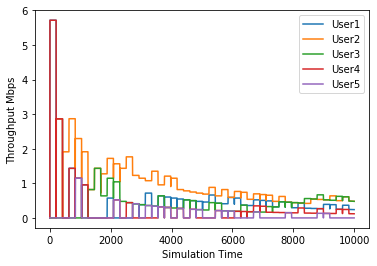

In [8]:
plt.plot(current_througput[0],label='User1')
plt.plot(current_througput[1],label='User2')
plt.plot(current_througput[2],label='User3')
plt.plot(current_througput[3],label='User4')
plt.plot(current_througput[4],label='User5')
plt.xlabel('Simulation Time')
plt.ylabel('Throughput Mbps')
plt.legend()
plt.savefig('tpt_all.eps',dpi=1000,format='eps')
#plt.scatter(x, y, color='r')